In [1]:
import codecs
import json
import numpy as np
import sklearn

In [2]:
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils

In [3]:
#Creating an embeddings object: 400k words, 50 dimensions
#glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)
word2vec=Embeddings('Data/word2vec-google-news-300.txt', gensim=False)

Loading Data/word2vec-google-news-300.txt embeddings
vectors shape: (3000000, 300), word2idx length: 3000000, vocab length: 3000000


In [4]:
#Getting the attributes of the embeddings 
vectors=word2vec.vectors
word2idx=word2vec.word2idx
vocab=word2vec.words
dict_vectors = word2vec.get_word_vector_dict()

In [5]:
#Verifying the attributes: there shouldn't be any null values
np.isnan(vectors).any()

False

In [6]:
#Removing puntuation and numbers from the embeddings
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = word2vec.limit_vocab(
    vectors, word2idx, vocab)


100%|██████████| 3000000/3000000 [00:01<00:00, 2238518.55it/s]


Size of limited vocabulary: 157356


In [7]:
#Checking if vector are normalized
np.apply_along_axis(np.linalg.norm, 1, vectors_cleaned)
#They are not!

array([1.32774749, 1.3839004 , 1.2739753 , ..., 0.79598862, 1.00951699,
       0.7968381 ])

## Hard-Debias Algorithm

#### Preliminaries

In [8]:
from Scripts.HardDebias import *

In [9]:
#Gender specific vocabulary from Bolukbasi's paper.
gender_specific = []
female_vocab = []
male_vocab = []
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific = female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))


In [10]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian", "hispanic"],
		["african", "caucasian", "asian", "hispanic"],
		["black", "white", "asian", "latino"],
		["africa", "europe", "asia", "mexico"],
		["africa", "america", "china", "latin-america"],
    ]
	}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [11]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
   
}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]



In [12]:
#Preparing the definite sets for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])

## What's the better way to find the Bias direction
The success of hard debiasing algorithms lies on their capacity to find the appropriate bias direction. 

In [13]:
#Find the words in the female_vocab that are also in the embeddings
female_words_emb=[word for word in female_vocab if word in dict_vec_cleaned.keys()]
male_words_emb = [word for word in male_vocab if word in dict_vec_cleaned.keys()]

print('Number of female words in embeddings:', len(female_words_emb))
print('Number of male words in embeddings:', len(male_words_emb))


Number of female words in embeddings: 201
Number of male words in embeddings: 208


In [14]:
#getting the gender directions
gen_dir_centralized=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
gen_dir=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=False)

#flattening them
gen_dir_centralized_flat=np.squeeze(gen_dir_centralized)
gen_dir_flat=np.squeeze(gen_dir)


Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components


In [15]:
#compute the similarity of a word through cosine similarity to the bias direction
def compute_similarity_to_bias_direction(dict_vec_cleaned, bias_direction):
    bias_direction = bias_direction / np.linalg.norm(bias_direction)
    similarity = {}
    for word in dict_vec_cleaned.keys():
        dict_vec_cleaned[word]=dict_vec_cleaned[word]/np.linalg.norm(dict_vec_cleaned[word])
        similarity[word]=utils.cosine_similarity(bias_direction, dict_vec_cleaned[word])
    return similarity


In [16]:
from Scripts.Evaluation import compute_gender_simple_bias, compute_similarity_to_bias_direction
similarity=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_flat)
similarity_centralized=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_centralized_flat)
simple_gender_bias=compute_gender_simple_bias(dict_vec_cleaned, dict_vec_cleaned['he'], dict_vec_cleaned['she'])

In [17]:
from operator import itemgetter
#function to get the most biased words in dict_vec_cleaned rated my similarity to the bias direction
def get_most_biased_words_similarity(similarity, n_words=2500):
    #get the absolute values of the similarity values
    similarity = {word: abs(sim) for word, sim in similarity.items()}
    #sort the similarity values
    sorted_similarity =sorted(similarity.items(), key=itemgetter(1), reverse=True)
    biased_words = [word for word, bias in sorted_similarity[:n_words*2]]
    neutral_words = [word for word, bias in sorted_similarity[-n_words:]]
    return biased_words, neutral_words

In [18]:
biased_words, neutral_words=get_most_biased_words_similarity(similarity, n_words=40000)


In [19]:
#count how many female_words_emb and male_words_emb are in the biased_words
def count_gendered_words_in_most_biased(female_words, male_words, biased_words):
    count_female=0
    count_male=0
    data={}
    for word in set(female_words):
        if word in set(biased_words):
            count_female+=1

    for word in set(male_words):
        if word in set(biased_words):
            count_male+=1
    
    data.update({'count_female': count_female, 'proportion_female': count_female/len(female_words),
                     'count_male': count_male, 'proportion_male': count_male/len(male_words)})
    return data

In [20]:
count_gendered_words_in_most_biased(female_words_emb, male_words_emb, biased_words)


{'count_female': 156,
 'proportion_female': 0.7761194029850746,
 'count_male': 119,
 'proportion_male': 0.5721153846153846}

In [21]:
biased_words_centralized, neutral_words_centralized=get_most_biased_words_similarity(similarity_centralized, n_words=40000)
count_gendered_words_in_most_biased(female_words_emb, male_words_emb, biased_words_centralized)

{'count_female': 179,
 'proportion_female': 0.8905472636815921,
 'count_male': 136,
 'proportion_male': 0.6538461538461539}

In [22]:
_, _, female_simple, male_simple, _ = utils.getting_biased_words(
    simple_gender_bias, def_sets['gender'], 40000, word2idx)

count_gendered_words_in_most_biased(female_words_emb, male_words_emb,female_simple+male_simple )

{'count_female': 174,
 'proportion_female': 0.8656716417910447,
 'count_male': 141,
 'proportion_male': 0.6778846153846154}

#### Now let's plot the results

In [23]:
import pandas as pd
#get a dataframe with the bias scores of the female_words_emb and male_words_emb in the similarity, similarity_centralized and simple_gender_bias
def get_df_bias_scores(word_list, similarity, similarity_centralized,simple_bias_score):
    scores={}
    for word in word_list:
        scores[word] = {"similarity_score": -(similarity[word]),
                        "centralized_similarity_score": (similarity_centralized[word]),
                        "simple_bias_score": simple_bias_score[word]}
    df=pd.DataFrame.from_dict(scores, orient='index')
    return df



In [24]:
df_female=get_df_bias_scores(female_words_emb, similarity, similarity_centralized,simple_gender_bias)
df_male=get_df_bias_scores(male_words_emb, similarity, similarity_centralized,simple_gender_bias)

In [25]:
#sort the dataframe according to the simple_gender_bias column
most_female_bias=df_female.sort_values(by=['simple_bias_score'], ascending=False, inplace=True)
most_male_bias=df_male.sort_values(by=['simple_bias_score'], ascending=True, inplace=True)

In [26]:
#plot a bar plot of the top 20 most biased words with all the scores of the three methods
import plotly_express as px

def plot_top_biased_words(df, n_words=20):
    df_top=df.head(n_words)
    #remove the simple_bias_score column
    df_top=df_top.drop(columns=['simple_bias_score'])
    df_top=df_top.reset_index()
    df_top=df_top.rename(columns={'index': 'word'})
    df_top=df_top.melt(id_vars=['word'], var_name='score_type', value_name='score')
    fig = px.bar(df_top, x="word", y="score", color="score_type", barmode="group")
    fig.show()


plot_top_biased_words(df_female, n_words=20)
plot_top_biased_words(df_male, n_words=20)


In [27]:
#turn the similarity scores into a dataframe to find the 20 words with the highest similarity score
df_similarity=pd.DataFrame.from_dict(similarity, orient='index')
df_similarity=df_similarity.rename(columns={0: 'similarity_score'})
df_similarity.sort_values(by=['similarity_score'], ascending=False, inplace=True)
df_similarity_male=df_similarity.head(20)
df_similarity_female=df_similarity.tail(20)

print('Top biased words according to the similarity score:',biased_words[:20])

#turn the centralized similarity scores into a dataframe to find the 20 words with the highest similarity score
df_similarity_centralized=pd.DataFrame.from_dict(similarity_centralized, orient='index')
df_similarity_centralized=df_similarity_centralized.rename(columns={0: 'similarity_score'})
df_similarity_centralized.sort_values(by=['similarity_score'], ascending=False, inplace=True)
df_centralized_female= df_similarity_centralized.head(20)
df_centralized_male=df_similarity_centralized.tail(20)

print('Top biased words according to the centralized similarity score:',biased_words_centralized[:20])

#simple_biased = {word: abs(sim) for word, sim in simple_gender_bias.items()}
df_simple_bias = pd.DataFrame.from_dict(simple_gender_bias, orient='index')
df_simple_bias=df_simple_bias.rename(columns={0: 'simple_bias_score'})
df_simple_bias.sort_values(by=['simple_bias_score'], ascending=False, inplace=True)
df_simple_fem=df_simple_bias.head(20)
df_simple_masc=df_simple_bias.tail(20)
print('Top biased words simple_score', list(df_simple_bias.head(10).index)+list(df_simple_bias.tail(10).index))



Top biased words according to the similarity score: ['john', 'johns', 'gal', 'mary', 'gillnet', 'streetwalking', 'cathouse', 'outcall', 'gals', 'lesbian', 'paddlewheeler', 'sampan', 'ingénue', 'prostitution', 'steamer', 'barge', 'chanteuse', 'houseboaters', 'humility', 'floozy']
Top biased words according to the centralized similarity score: ['she', 'her', 'hers', 'herself', 'gal', 'frontwoman', 'motherhood', 'pagaent', 'songstress', 'heroine', 'housewife', 'businesswoman', 'actress', 'comedienne', 'chairwoman', 'girlhood', 'chanteuse', 'minx', 'covergirl', 'everywoman']
Top biased words simple_score ['her', 'she', 'pagaent', 'hers', 'motherhood', 'frontwoman', 'momager', 'pregancy', 'girlhood', 'covergirl', 'andhe', 'guy', 'boyhood', 'journeyman', 'countryman', 'himslef', 'him', 'his', 'himself', 'he']


In [28]:
df_centralized_male


,similarity_score
burly,-0.242348
underacheiving,-0.245687
superpest,-0.245766
verballing,-0.245950
servicable,-0.249707
fugazy,-0.252872
beard,-0.254596
his,-0.257156
rooke,-0.259586
consiglieri,-0.263006


In [29]:
#get a histogram of the similarity.values()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(similarity, title):
    plt.hist(similarity.values())
    plt.title(title)
    plt.show()

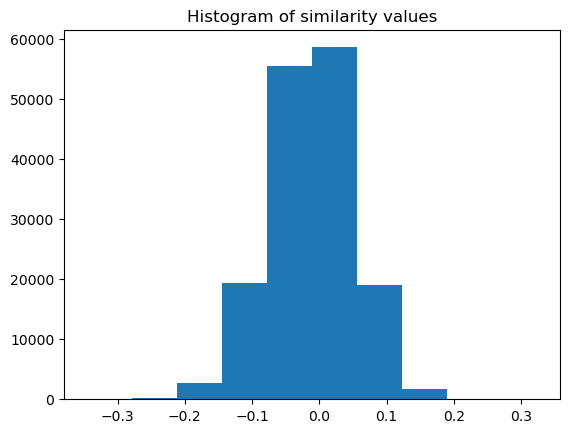

In [30]:
plot_histogram(similarity, 'Histogram of similarity values')

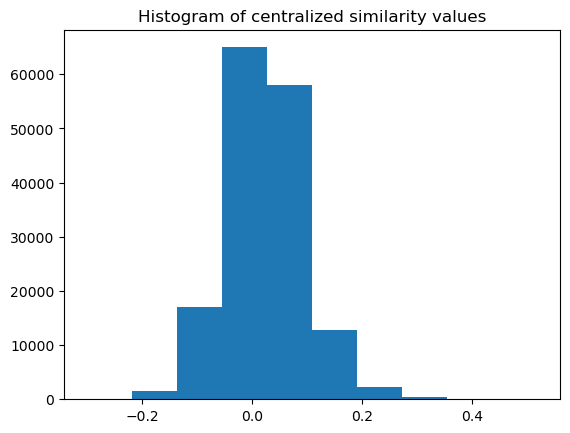

In [31]:
plot_histogram(similarity_centralized, 'Histogram of centralized similarity values')


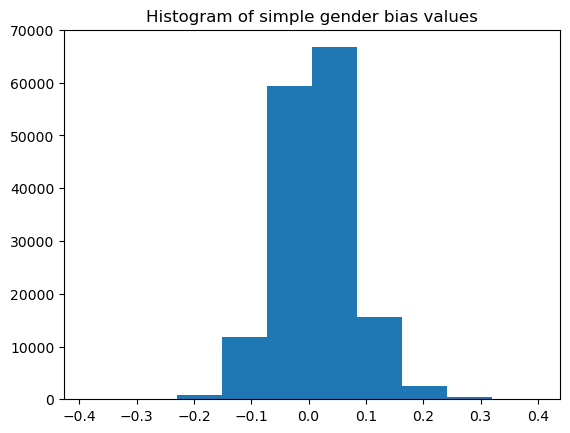

In [32]:
plot_histogram(simple_gender_bias, 'Histogram of simple gender bias values')


In [33]:
#get the words in similirity that have values 0
def get_words_with_value_zero(similarity):
    words=[]
    for word in similarity.keys():
        if np.allclose(similarity[word],0.5):
            words.append(word)
    return words

In [34]:
get_words_with_value_zero(similarity)

[]